In [1]:
import nflgame

# returns the field position as the number of yards away from the opposing team's end zone
def field_pos_to_number(pos):
    pos = pos.split(" ")
    if pos[0] == "MIDFIELD":
        return 50
    elif pos[0] == "OWN":
        return 100-int(pos[1])
    elif pos[0] == "OPP":
        return int(pos[1])
    
# returns the current game clock as a quarter, clock tuple
def clock_to_nums(clock):
    clock = clock.split(" ")
    clock[0] = min(int(clock[0][1:]), 5)
    return clock[0], clock[1]

# returns the current play in a different format
def convert_play(p):
    quarter, time = clock_to_nums(p[2])
    return [quarter, time, p[3], p[4], field_pos_to_number(p[5]), p[-5], p[-4], p[-3], p[-2], p[-1]]
    
# get number of points scored on the conversion attempt after a touchdown
def get_conversion(plays, scores, i):
    # use list of scoring plays to figure out conversions
    if i < len(scores):
        #print(scores[i])
        if " TD " in scores[i]:
            if "failed" in scores[i]:
                return 0, i+1
            if "kick is good" in scores[i]:
                return 1, i+1
            if "run)" in scores[i] or "pass)" in scores[i]:
                return 2, i+1
            if i < len(scores)-1 and "defensive two point conversion" in scores[i+1]:
                return -1, i+2
    return 0, i+1

# get all plays for a given game in the proper format
def get_all_plays2(game, spread):   
    plays = nflgame.combine_plays([game])
    scores = game.scores
    score_index = 0
    home = 0
    away = 0
    win = (game.score_home >= game.score_away)
    plays2 = []
    for p in plays:
        plays2.append(p)

    all_plays = []
    for i in range(len(plays2)):
        p = plays2[i]
        if (p.down > 0 and str(p.time) != "None" and str(p.yardline) != "None"): # or p.note == "KICKOFF":
            # add play to all plays
            temp_play = [game.home, game.away, str(p.time), p.down, p.yards_togo, 
                         str(p.yardline), p.home, home, away, spread, win]
            all_plays.append(convert_play(temp_play))
#         if (not p.note == None) and len(p.note) >= 2 and (p.note[:2] == "2P" or p.note[:2] == "XP"):
#             print(p.note)
        # do scoring stuff
        if p.note == "TD":
            pts = 6
            is_home = p.home
            if p.punting_tot == 1:
                is_home = (not is_home)
            if p.defense_tds == 1:
                is_home = (not is_home)
#             is_home = True
#             if (not p.home and p.defense_tds != 1) or (p.home and p.defense_tds == 1):
#                 is_home = False
            conv, score_index = get_conversion(plays2, scores, score_index)
            # add conversion points if it wasn't a defensive 2 point conversion
            if conv != -1:
                pts += conv
            if is_home:
                home += pts
            else:
                away += pts
            # handle defensive 2 point conversion 
            if conv == -1:
                if is_home:
                    away += 2
                else:
                    home += 2
            #print(str(home) + "-" + str(away))

        elif p.note == "FG":
            if p.home:
                home += 3
            else:
                away += 3
            score_index += 1
                
        elif p.note == "SAF":
            if scores[score_index].split("-")[0][:-1] == str(game.home):
                home += 2
            else:
                away += 2
            score_index += 1

    return home, away, all_plays

def fix_name(t):
    if t == "SD":
        t = "LAC"
    if t == "LA" or t == "STL":
        t = "LAR"
    if t == "JAC":
        t = "JAX"
    return t

Updating (2019, 'POST', 22)
Week POST22 of 2019 was either empty, or it couldn't be fetched from NFL.com. Aborting.


## spread data

In [2]:
import pandas as pd

data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)
data.head()

,schedule_season,schedule_week,date,team1,team2,score1,score2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,qbelo1_pre,qbelo2_pre,qbelo_prob1,qbelo_prob2,elo_spread,qb_spread,vegas_spread,result
7222,2009,1,2009-09-10,PIT,TEN,13.0,10.0,1644.566,1592.943,0.661802,0.338198,1610.471883,1553.197070,0.658697,0.341303,-4.66492,-4.568719,-6.5,-3.0
7223,2009,1,2009-09-13,ARI,SF,16.0,20.0,1550.108,1453.624,0.716989,0.283011,1526.281842,1454.182452,0.694459,0.305541,-6.45936,-5.705234,-4.5,4.0
7224,2009,1,2009-09-13,ATL,MIA,19.0,7.0,1527.719,1514.267,0.611021,0.388979,1517.459685,1470.611588,0.640480,0.359520,-3.13808,-4.012509,-4.0,-12.0
7225,2009,1,2009-09-13,BAL,KC,38.0,24.0,1613.810,1358.667,0.863290,0.136710,1544.975085,1395.673582,0.776936,0.223064,-12.80572,-8.671284,-13.0,-14.0
7226,2009,1,2009-09-13,CAR,PHI,10.0,38.0,1529.671,1603.684,0.487032,0.512968,1520.135114,1570.740791,0.490166,0.509834,0.36052,0.273370,2.5,28.0


## data cleaning

In [5]:
import matplotlib.pyplot as plt

# get all plays from all weeks in weeks and all seasons in years. calls get_all_plays2
def get_plays(years, weeks, indexes=-1):
    all_plays = []
    for y in years:
        print(y)
        for w in weeks:
            #print(w)
            try:
                games = nflgame.games(y, week=w, kind='REG')
            except:
                continue
            current = data[(data["schedule_season"] == y) & (data["schedule_week"] == str(w))]
            if not indexes == -1:
                games = [games[i] for i in indexes]
            for g in games:
                t1 = g.home
                t2 = g.away
                t1 = fix_name(t1)
                t2 = fix_name(t2)
                #print(t2)
                spread = list(current.loc[(current["team1"] == t1) & (current["team2"] == t2)]["vegas_spread"])
                if len(spread) > 0:
                    h, a, cur_plays = get_all_plays2(g, spread[0])
                    if h != g.score_home or a != g.score_away:
                        #print("Actual: " + str(g.score_home) + "-" + str(g.score_away) + ", Mine: " + str(h) + "-" + 
                          #    str(a) + " " + str(g.home) + " " +str(g.away))
                        continue
                    all_plays += cur_plays
    return all_plays

# final model?
def collect_plays(all_plays):
    # collect plays and add interaction terms
    x_data = []
    y_data = []
    for p in all_plays:
        qtr = p[0]
        time = p[1].split(":")
        if len(time[0]) == 0:
            continue
        mins_left = 15*(4-min(qtr,4))+int(time[0])
        secs_left = int(time[1])
        time_left = round(mins_left + secs_left/60.,2)

        x_data.append([time_left]+p[2:-1])
        y_data.append(1 if p[-1] else 0)

    df = pd.DataFrame(x_data, columns=["time", "down", "distance", "fieldpos", "homeposs", "score_home", 
                                      "score_away", "spread"])

    # basic terms
    df["scorediff"] = df["score_home"] - df["score_away"]
    df["down1"] = df["down"].apply(lambda x : 1 if x == 1 else 0)
    df["down2"] = df["down"].apply(lambda x : 1 if x == 2 else 0)
    df["down3"] = df["down"].apply(lambda x : 1 if x == 3 else 0)
    df["down4"] = df["down"].apply(lambda x : 1 if x == 4 else 0)
    df["homeposs"] = df["homeposs"].apply(lambda x : 1 if x else 0)
    
    # interaction terms
    df["down1*poss"] = df["down1"] * df["homeposs"]
    df["down2*poss"] = df["down2"] * df["homeposs"]
    df["down3*poss"] = df["down3"] * df["homeposs"]
    df["down4*poss"] = df["down4"] * df["homeposs"]
    df["distance*poss"] = df["distance"] * df["homeposs"]
    df["fieldpos*poss"] = df["fieldpos"] * df["homeposs"]
    
    # more interaction terms
    df["time*poss"] = (60-df["time"]) * df["homeposs"]
    df["time*spread"] = df["time"] * df["spread"]
    df["time*scorediff"] = (60-df["time"]) * df["scorediff"]
    df["fgrange"] = df["fieldpos"].apply(lambda x : 1 if x <= 35 else 0)
    df["fgrange*poss"] = df["fgrange"] * df["homeposs"]

    # additional terms
    df["last5"] = df["time"].apply(lambda x : 1 if x <= 5 else 0)
    df["close"] = df["scorediff"].apply(lambda x : 1 if abs(x) <= 8 else 0)
    df["last5min_close"] = df["last5"] * df["close"]
    df["last5min_close_poss"] = df["last5min_close"] * df["homeposs"]
    
    # score correction
    df["sqrt_time"] = df["time"].apply(lambda x : 1 + np.sqrt(x))
    df["score_correction"] = df["scorediff"] / df["sqrt_time"]
    
    df.drop(["score_correction", "homeposs", "down", "score_home", "score_away", "last5", 
             "close", "sqrt_time"], axis=1, inplace=True)
    
    return df, y_data

def remove_features(df):
    df.drop(["time*poss", "time*spread", "time*scorediff", "fgrange", "fgrange*poss", 
             "last5min_close", "last5min_close_poss"], axis=1, inplace=True)
    return df

def check_wp(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

def check_wp2(x, y, model, threshold):
    y_pred = model.predict(x)
    time_left = list(x["time"])
    
    results = []
    for i in range(len(y_pred)):
        if time_left[i] > 5:
            continue
        if abs(y_pred[i]-threshold) <= 0.01:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
    #print(count)
    m = np.mean(results)
    return m, np.sqrt(m*(1-m)/len(results))

# check accuracy using original mse thing
def check_model_accuracy(test_x, test_y, model, last5):
    x = np.arange(0,1.01,0.05)
    y = []
    ses = []
    se = 0
    for i in x:
        if not last5:
            cur_mean, cur_se = check_wp(test_x, test_y, model, i)
        else:
            cur_mean, cur_se = check_wp2(test_x, test_y, model, i)
        y.append(cur_mean)
        ses.append(cur_se)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)) + ", SE = " + str(round(cur_se, 3)))
        se += (cur_mean-i)**2

    print("")
    print("mse: " + str(se/len(x)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy2(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_se, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        se += cur_se
        count += cur_num

    print("")
    print("brier score: " + str(se/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
def get_brier(x, y, model, threshold):
    y_pred = model.predict(x)
    
    results = []
    errors = []
    
    y_pred = list(y_pred)
    for i in range(len(y_pred)):
        if abs(y_pred[i]-threshold) <= 0.025:
            if y[i] == 1:
                results.append(1)
            else:
                results.append(0)
            errors.append((y[i]-y_pred[i])**2)
    #print(count)
    return np.mean(results), sum(errors), len(errors)

# check accuracy using the brier score
def check_model_accuracy_all(test_x, test_y, model):
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score
def check_model_accuracy_times(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
# check accuracy using the brier score and does the binary prediction thing
def check_model_accuracy_times2(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)))# + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num
        
    # do binary thing
    y_pred = model.predict(test_x)
    b_y_pred = [1 if val > 0.5 else 0 for val in y_pred]
    correct = 0
    for i in range(len(b_y_pred)):
        if b_y_pred[i] == test_y[i]:
            correct += 1

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))
    print("binary prediction accuracy: " + str(correct/len(b_y_pred)))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    fig = plt.gcf()
    plt.show()
    return fig

In [23]:
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

train_fraction = 0.7

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = get_plays(years,weeks)

x_data, y_data = collect_plays(plays)

# convert to lists, randomize
cols = list(x_data)
x_data = x_data.values.tolist()
alldata = list(zip(x_data, y_data))
random.shuffle(alldata)
x_data, y_data = zip(*alldata)
x_data = list(x_data)
y_data = list(y_data)

# simpler model
x_data2 = pd.DataFrame(data=np.array(x_data), columns=cols)
x_data2 = remove_features(x_data2)
cols2 = list(x_data2)
x_data2 = x_data2.values.tolist()

# take the appropriate training and testing sets
num_points = int(train_fraction*len(x_data))
train_x = pd.DataFrame(x_data[:num_points], columns=cols)
train_y = y_data[:num_points]
test_x = pd.DataFrame(x_data[num_points:], columns=cols)
test_y = y_data[num_points:]

# training and testing for simpler model
train_x2 = pd.DataFrame(x_data2[:num_points], columns=cols2)
test_x2 = pd.DataFrame(x_data2[num_points:], columns=cols2)

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [24]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
regressor.fit(train_x2, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

0.0: 0.002
0.05: 0.02
0.1: 0.06
0.15: 0.104
0.2: 0.167
0.25: 0.229
0.3: 0.285
0.35: 0.329
0.4: 0.386
0.45: 0.438
0.5: 0.498
0.55: 0.541
0.6: 0.591
0.65: 0.638
0.7: 0.715
0.75: 0.78
0.8: 0.829
0.85: 0.882
0.9: 0.94
0.95: 0.978
1.0: 0.999

mse: 0.0006082422292520638
brier score: 0.11872594957753


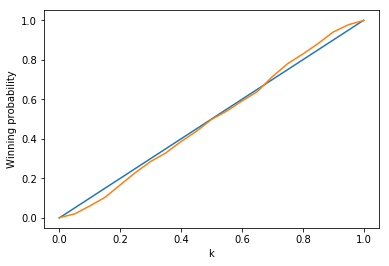

In [6]:
check_model_accuracy_times(test_x2, test_y, regressor, 60, 0)

0.0: 0.0
0.05: 0.009
0.1: 0.047
0.15: 0.094
0.2: 0.151
0.25: 0.217
0.3: 0.239
0.35: 0.352
0.4: 0.403
0.45: 0.363
0.5: 0.467
0.55: 0.562
0.6: 0.64
0.65: 0.647
0.7: 0.716
0.75: 0.786
0.8: 0.84
0.85: 0.924
0.9: 0.97
0.95: 0.99
1.0: 1.0

mse: 0.0019197193559484908
brier score: 0.06220919749054801


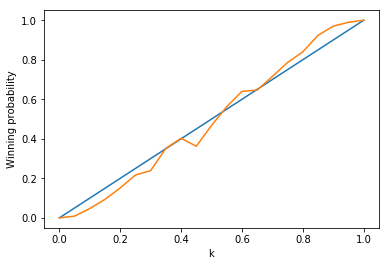

In [7]:
check_model_accuracy_times(test_x2, test_y, regressor, 5, 0)

In [27]:
from sklearn.ensemble import RandomForestRegressor

regressor4 = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
regressor4.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

0.0: 0.002
0.05: 0.017
0.1: 0.06
0.15: 0.109
0.2: 0.157
0.25: 0.221
0.3: 0.27
0.35: 0.329
0.4: 0.401
0.45: 0.425
0.5: 0.497
0.55: 0.537
0.6: 0.602
0.65: 0.662
0.7: 0.698
0.75: 0.77
0.8: 0.829
0.85: 0.893
0.9: 0.941
0.95: 0.977
1.0: 0.999

mse: 0.000702277348723365
brier score: 0.11721337186191859


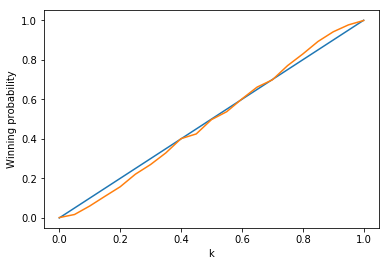

0.0: 0.0
0.05: 0.012
0.1: 0.067
0.15: 0.089
0.2: 0.137
0.25: 0.179
0.3: 0.284
0.35: 0.258
0.4: 0.395
0.45: 0.389
0.5: 0.545
0.55: 0.582
0.6: 0.626
0.65: 0.668
0.7: 0.677
0.75: 0.775
0.8: 0.844
0.85: 0.918
0.9: 0.964
0.95: 0.989
1.0: 1.0

mse: 0.002145932315948016
brier score: 0.061723002487421096


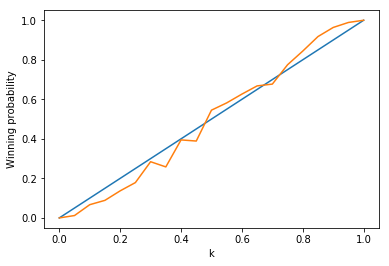

In [9]:
# bins
check_model_accuracy_times(test_x, test_y, regressor4, 60, 0)
check_model_accuracy_times(test_x, test_y, regressor4, 5, 0)

0.0: 0.001
0.05: 0.021
0.1: 0.046
0.15: 0.103
0.2: 0.164
0.25: 0.219
0.3: 0.281
0.35: 0.326
0.4: 0.378
0.45: 0.458
0.5: 0.509
0.55: 0.537
0.6: 0.588
0.65: 0.654
0.7: 0.71
0.75: 0.77
0.8: 0.819
0.85: 0.876
0.9: 0.932
0.95: 0.978
1.0: 1.0

mse: 0.0006450330093275244
brier score: 0.09577468632185861


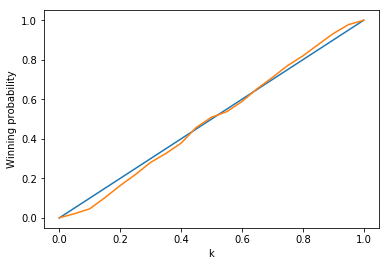

In [9]:
check_model_accuracy_times(test_x, test_y, regressor4, 60, 0)

0.0: 0.0
0.05: 0.03
0.1: 0.017
0.15: 0.116
0.2: 0.221
0.25: 0.214
0.3: 0.235
0.35: 0.333
0.4: 0.33
0.45: 0.449
0.5: 0.509
0.55: 0.56
0.6: 0.725
0.65: 0.652
0.7: 0.71
0.75: 0.802
0.8: 0.771
0.85: 0.875
0.9: 0.956
0.95: 0.967
1.0: 1.0

mse: 0.002056922807576789
brier score: 0.04102433349361375


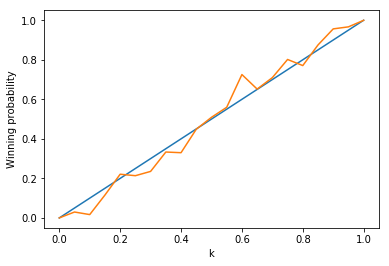

In [10]:
check_model_accuracy_times(test_x, test_y, regressor4, 5, 0)

simplified forests full game
0.0: 0.0
0.05: 0.016
0.1: 0.072
0.15: 0.111
0.2: 0.168
0.25: 0.235
0.3: 0.275
0.35: 0.333
0.4: 0.405
0.45: 0.434
0.5: 0.482
0.55: 0.552
0.6: 0.598
0.65: 0.662
0.7: 0.71
0.75: 0.759
0.8: 0.827
0.85: 0.884
0.9: 0.932
0.95: 0.979
1.0: 1.0

mse: 0.0004920134006484075
brier score: 0.09444110076404875
binary prediction accuracy: 0.8233144398023718


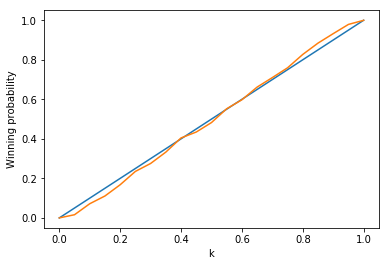

full forests full game
0.0: 0.0
0.05: 0.017
0.1: 0.045
0.15: 0.123
0.2: 0.147
0.25: 0.236
0.3: 0.273
0.35: 0.346
0.4: 0.388
0.45: 0.464
0.5: 0.493
0.55: 0.553
0.6: 0.602
0.65: 0.684
0.7: 0.72
0.75: 0.776
0.8: 0.822
0.85: 0.894
0.9: 0.94
0.95: 0.98
1.0: 1.0

mse: 0.0007719745114491758
brier score: 0.09341593126116425
binary prediction accuracy: 0.8262948277850217


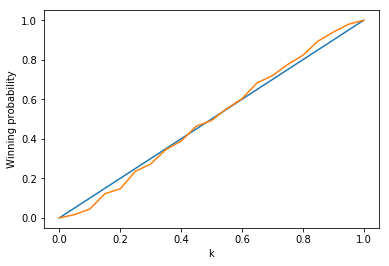

In [16]:
print("simplified forests full game")
check_model_accuracy_times2(test_x2, test_y, regressor, 60, 0)

print("full forests full game")
check_model_accuracy_times2(test_x, test_y, regressor4, 60, 0)

simplified forests full game
0.0: 0.002
0.05: 0.02
0.1: 0.06
0.15: 0.104
0.2: 0.167
0.25: 0.229
0.3: 0.285
0.35: 0.329
0.4: 0.386
0.45: 0.438
0.5: 0.498
0.55: 0.541
0.6: 0.591
0.65: 0.638
0.7: 0.715
0.75: 0.78
0.8: 0.829
0.85: 0.882
0.9: 0.94
0.95: 0.978
1.0: 0.999

mse: 0.0006082422292520638
brier score: 0.11872594957753
binary prediction accuracy: 0.8208573937571516


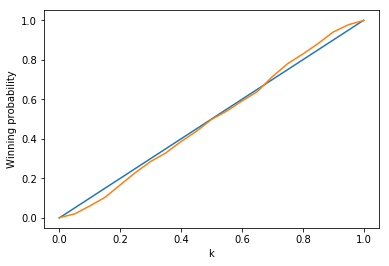

full forests full game
0.0: 0.002
0.05: 0.017
0.1: 0.06
0.15: 0.109
0.2: 0.157
0.25: 0.221
0.3: 0.27
0.35: 0.329
0.4: 0.401
0.45: 0.425
0.5: 0.497
0.55: 0.537
0.6: 0.602
0.65: 0.662
0.7: 0.698
0.75: 0.77
0.8: 0.829
0.85: 0.893
0.9: 0.941
0.95: 0.977
1.0: 0.999

mse: 0.000702277348723365
brier score: 0.11721337186191859
binary prediction accuracy: 0.8244232150935363


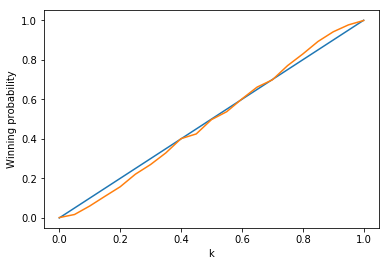

In [10]:
# bins
print("simplified forests full game")
check_model_accuracy_times2(test_x2, test_y, regressor, 60, 0)

print("full forests full game")
check_model_accuracy_times2(test_x, test_y, regressor4, 60, 0)

#### save figures

0.0: 0.002
0.05: 0.018
0.1: 0.052
0.15: 0.103
0.2: 0.163
0.25: 0.215
0.3: 0.282
0.35: 0.328
0.4: 0.393
0.45: 0.438
0.5: 0.485
0.55: 0.546
0.6: 0.589
0.65: 0.653
0.7: 0.716
0.75: 0.77
0.8: 0.824
0.85: 0.892
0.9: 0.94
0.95: 0.976
1.0: 0.998

mse: 0.0007016881338436648
brier score: 0.11836760104361584
binary prediction accuracy: 0.8219306882389987


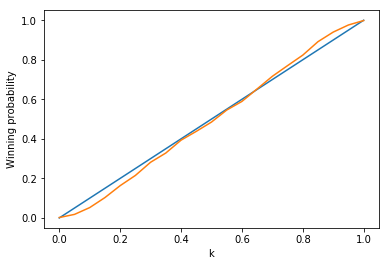

0.0: 0.0
0.05: 0.015
0.1: 0.049
0.15: 0.106
0.2: 0.139
0.25: 0.168
0.3: 0.267
0.35: 0.271
0.4: 0.37
0.45: 0.47
0.5: 0.523
0.55: 0.522
0.6: 0.617
0.65: 0.644
0.7: 0.723
0.75: 0.736
0.8: 0.781
0.85: 0.922
0.9: 0.95
0.95: 0.978
1.0: 1.0

mse: 0.0017085560897795854
brier score: 0.06412974201741194
binary prediction accuracy: 0.9057370517928287


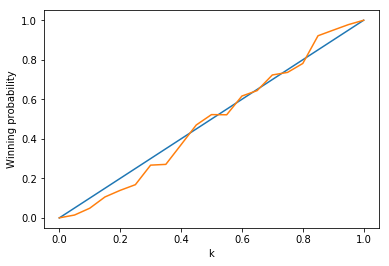

0.0: 0.001
0.05: 0.014
0.1: 0.046
0.15: 0.09
0.2: 0.154
0.25: 0.219
0.3: 0.278
0.35: 0.324
0.4: 0.382
0.45: 0.442
0.5: 0.497
0.55: 0.547
0.6: 0.599
0.65: 0.642
0.7: 0.722
0.75: 0.774
0.8: 0.833
0.85: 0.885
0.9: 0.941
0.95: 0.979
1.0: 0.998

mse: 0.0008771151596631555
brier score: 0.1163835020973896
binary prediction accuracy: 0.8266851166875117


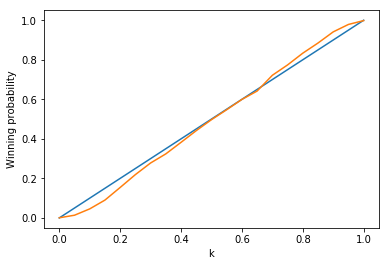

0.0: 0.0
0.05: 0.009
0.1: 0.038
0.15: 0.054
0.2: 0.156
0.25: 0.179
0.3: 0.275
0.35: 0.256
0.4: 0.345
0.45: 0.476
0.5: 0.46
0.55: 0.602
0.6: 0.633
0.65: 0.605
0.7: 0.707
0.75: 0.771
0.8: 0.839
0.85: 0.893
0.9: 0.951
0.95: 0.98
1.0: 0.999

mse: 0.0023671826917417175
brier score: 0.06297045290392904
binary prediction accuracy: 0.909402390438247


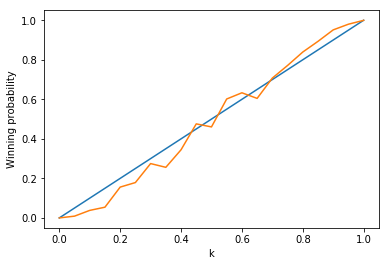

In [28]:
fig = check_model_accuracy_times2(test_x2, test_y, regressor, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/random_forests/randomsplits/simplified_60.png")

fig = check_model_accuracy_times2(test_x2, test_y, regressor, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/random_forests/randomsplits/simplified_5.png")

fig = check_model_accuracy_times2(test_x, test_y, regressor4, 60, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/random_forests/randomsplits/full_60.png")

fig = check_model_accuracy_times2(test_x, test_y, regressor4, 5, 0)
fig.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/random_forests/randomsplits/full_5.png")

## random forests on last 5 minutes only

In [23]:
temp = pd.concat([train_x, pd.DataFrame(data=train_y, columns=["y"])], axis=1)
train_x_last5 = temp[temp["time"] <= 5]
train_y_last5 = train_x_last5["y"].tolist()
train_x_last5.drop(["y"], axis=1, inplace=True)

regressor2 = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
regressor2.fit(train_x_last5, train_y_last5)

/Users/Bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

0.0: 0.001
0.05: 0.009
0.1: 0.036
0.15: 0.052
0.2: 0.137
0.25: 0.151
0.3: 0.188
0.35: 0.216
0.4: 0.299
0.45: 0.357
0.5: 0.406
0.55: 0.583
0.6: 0.636
0.65: 0.712
0.7: 0.763
0.75: 0.888
0.8: 0.893
0.85: 0.902
0.9: 0.973
0.95: 0.988
1.0: 1.0

mse: 0.006411327503362256
brier score: 0.03340460253705804


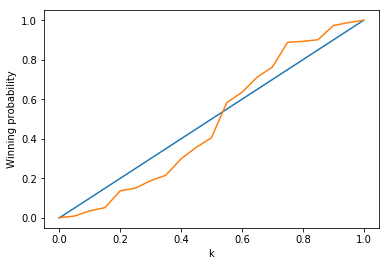

In [56]:
check_model_accuracy_times(test_x, test_y, regressor2, 5, 0)

In [25]:
temp = pd.concat([train_x2, pd.DataFrame(data=train_y, columns=["y"])], axis=1)
train_x_last5 = temp[temp["time"] <= 5]
train_y_last5 = train_x_last5["y"].tolist()
train_x_last5.drop(["y"], axis=1, inplace=True)

regressor3 = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
regressor3.fit(train_x_last5, train_y_last5)

/Users/Bill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

0.0: 0.001
0.05: 0.0
0.1: 0.078
0.15: 0.032
0.2: 0.111
0.25: 0.133
0.3: 0.227
0.35: 0.296
0.4: 0.247
0.45: 0.4
0.5: 0.452
0.55: 0.57
0.6: 0.681
0.65: 0.709
0.7: 0.793
0.75: 0.796
0.8: 0.889
0.85: 0.904
0.9: 0.956
0.95: 0.988
1.0: 1.0

mse: 0.005303029146894834
brier score: 0.03479413951966222


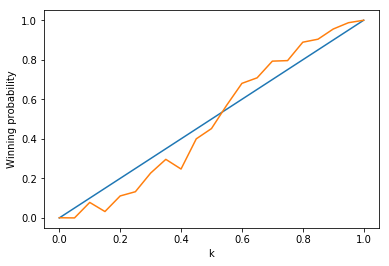

In [57]:
check_model_accuracy_times(test_x2, test_y, regressor3, 5, 0)

## PCA

In [42]:
# standardize data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cols = list(train_x)
train_x_values = StandardScaler().fit_transform(train_x.values)
new_train_x = pd.DataFrame(data=train_x_values, columns=cols)

# PCA
num_comp = 8
pca = PCA(n_components=num_comp)
principalComponents = pca.fit_transform(new_train_x)
principalDf = pd.DataFrame(data = principalComponents, columns = ["pc%d" %(i) for i in range(1, num_comp+1)])

0: 0.15
1: 0.27
2: 0.38
3: 0.48
4: 0.57
5: 0.66
6: 0.75
7: 0.81
8: 0.85
9: 0.89
10: 0.91
11: 0.93
12: 0.95
13: 0.96
14: 0.97
15: 0.98
16: 0.99
17: 0.99
18: 1.0
19: 1.0
20: 1.0
21: 1.0


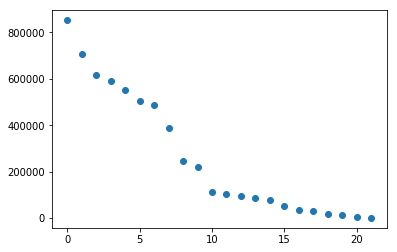

In [43]:
n,d = np.shape(new_train_x)

corr = np.dot(new_train_x.T,new_train_x)
eig_val,eig_vect = np.linalg.eigh(corr) #compute the eigenvalues and eigenvectors
idx = eig_val.argsort()[::-1]   # sort the eigenvalues
eig_val = eig_val[idx] # eigenvalues in decreasing order
eig_vect = eig_vect[:,idx] # eigenvectors in decreasing order

# cumulative fraction of variance explained
tot = sum(eig_val)
cum = 0
for i in range(len(eig_val)):
    cum += eig_val[i]
    print(str(i) + ": " + str(round(cum/tot,2)))
    
plt.scatter(range(d),eig_val)
plt.show()

In [31]:
# fit tree
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators = 100, min_samples_leaf=5)
regressor.fit(principalDf, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [12]:
# standardize data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cols = list(train_x2)
train_x_values = StandardScaler().fit_transform(train_x2.values)
new_train_x2 = pd.DataFrame(data=train_x_values, columns=cols)

# PCA
num_comp = 8
pca = PCA(n_components=num_comp)
principalComponents = pca.fit_transform(new_train_x2)
principalDf2 = pd.DataFrame(data = principalComponents, columns = ["pc%d" %(i) for i in range(1, num_comp+1)])

In [13]:
# fit tree
from sklearn.ensemble import RandomForestRegressor

regressor5 = RandomForestRegressor(n_estimators = 100, min_samples_leaf=5)
regressor5.fit(principalDf2, train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
# check accuracy using the brier score
def check_model_accuracy_times_pca(old_old_test_x, old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_old_test_x["time"] <= start_time) & 
                               (old_old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    se = 0
    count = 0
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean)
        print(str(round(i,2)) + ": " + str(round(cur_mean,3)) + ", brier: " + str(round(cur_brier/cur_num, 3)))
        brier += cur_brier
        se += (cur_mean-i)**2
        count += cur_num

    print("")
    print("mse: " + str(se/len(x)))
    print("brier score: " + str(brier/count))

    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,y)
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()

0.0: 0.003, brier: 0.003
0.05: 0.032, brier: 0.031
0.1: 0.068, brier: 0.065
0.15: 0.14, brier: 0.12
0.2: 0.167, brier: 0.14
0.25: 0.213, brier: 0.169
0.3: 0.274, brier: 0.199
0.35: 0.34, brier: 0.224
0.4: 0.378, brier: 0.235
0.45: 0.44, brier: 0.247
0.5: 0.494, brier: 0.25
0.55: 0.554, brier: 0.247
0.6: 0.608, brier: 0.239
0.65: 0.686, brier: 0.217
0.7: 0.711, brier: 0.206
0.75: 0.788, brier: 0.168
0.8: 0.83, brier: 0.142
0.85: 0.888, brier: 0.101
0.9: 0.916, brier: 0.077
0.95: 0.96, brier: 0.038
1.0: 0.997, brier: 0.003

mse: 0.0005229484741642584
brier score: 0.12145260683261684


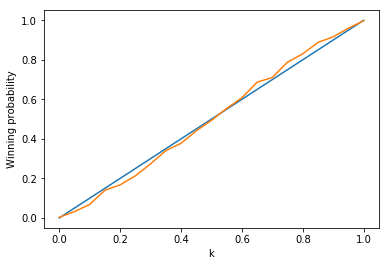

In [51]:
# standardize test data
test_x_values = StandardScaler().fit_transform(test_x.values)
new_test_x = pd.DataFrame(data=test_x_values, columns=cols)

# fit test data with PCA
test_pca = pca.fit_transform(new_test_x)
test_pca = pd.DataFrame(data=test_pca, columns=["pc%d" %(i) for i in range(1, num_comp+1)])

check_model_accuracy_times_pca(test_x, test_pca, test_y, regressor, 60, 0)

0.0: 0.002, brier: 0.002
0.05: 0.023, brier: 0.023
0.1: 0.039, brier: 0.041
0.15: 0.112, brier: 0.101
0.2: 0.152, brier: 0.131
0.25: 0.17, brier: 0.147
0.3: 0.241, brier: 0.186
0.35: 0.296, brier: 0.211
0.4: 0.33, brier: 0.225
0.45: 0.364, brier: 0.24
0.5: 0.488, brier: 0.25
0.55: 0.55, brier: 0.247
0.6: 0.592, brier: 0.241
0.65: 0.651, brier: 0.228
0.7: 0.649, brier: 0.231
0.75: 0.789, brier: 0.167
0.8: 0.833, brier: 0.14
0.85: 0.913, brier: 0.083
0.9: 0.929, brier: 0.067
0.95: 0.977, brier: 0.023
1.0: 1.0, brier: 0.0

mse: 0.002113676146229134
brier score: 0.05948596516771668


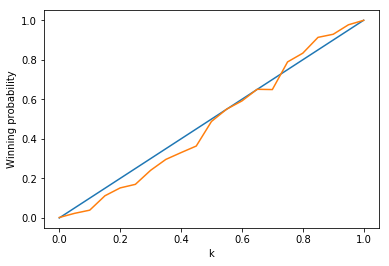

In [52]:
check_model_accuracy_times_pca(test_x, test_pca, test_y, regressor, 5, 0)

0.0: 0.003, brier: 0.003
0.05: 0.058, brier: 0.055
0.1: 0.106, brier: 0.095
0.15: 0.156, brier: 0.132
0.2: 0.206, brier: 0.163
0.25: 0.263, brier: 0.194
0.3: 0.323, brier: 0.219
0.35: 0.375, brier: 0.235
0.4: 0.423, brier: 0.244
0.45: 0.464, brier: 0.249
0.5: 0.518, brier: 0.25
0.55: 0.557, brier: 0.247
0.6: 0.613, brier: 0.237
0.65: 0.664, brier: 0.223
0.7: 0.727, brier: 0.199
0.75: 0.758, brier: 0.183
0.8: 0.807, brier: 0.156
0.85: 0.855, brier: 0.124
0.9: 0.905, brier: 0.086
0.95: 0.947, brier: 0.051
1.0: 0.995, brier: 0.005

mse: 0.00018682146266047744
brier score: 0.14959008331700543


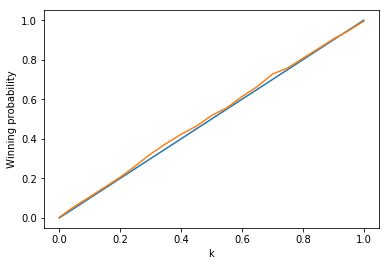

0.0: 0.0, brier: 0.0
0.05: 0.02, brier: 0.02
0.1: 0.085, brier: 0.078
0.15: 0.071, brier: 0.073
0.2: 0.149, brier: 0.13
0.25: 0.178, brier: 0.151
0.3: 0.253, brier: 0.191
0.35: 0.337, brier: 0.223
0.4: 0.393, brier: 0.239
0.45: 0.439, brier: 0.246
0.5: 0.506, brier: 0.25
0.55: 0.547, brier: 0.248
0.6: 0.604, brier: 0.239
0.65: 0.702, brier: 0.212
0.7: 0.721, brier: 0.201
0.75: 0.851, brier: 0.137
0.8: 0.834, brier: 0.139
0.85: 0.882, brier: 0.105
0.9: 0.949, brier: 0.051
0.95: 0.956, brier: 0.042
1.0: 0.995, brier: 0.005

mse: 0.0016949164899545475
brier score: 0.0932663138712583


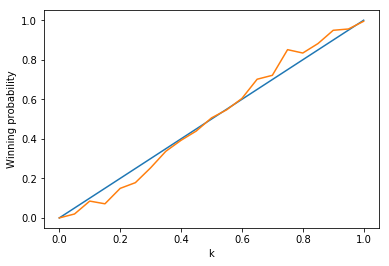

In [17]:
# standardize test data
test_x_values = StandardScaler().fit_transform(test_x2.values)
new_test_x2 = pd.DataFrame(data=test_x_values, columns=cols)

# fit test data with PCA
test_pca2 = pca.fit_transform(new_test_x2)
test_pca2 = pd.DataFrame(data=test_pca2, columns=["pc%d" %(i) for i in range(1, num_comp+1)])

check_model_accuracy_times_pca(test_x2, test_pca2, test_y, regressor5, 60, 0)

check_model_accuracy_times_pca(test_x2, test_pca2, test_y, regressor5, 5, 0)

## cross validation, splitting by season

In [5]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# get spread data
data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

# get training and testing data
test_fraction = 0.3

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = []
for y in years:
    plays.append(get_plays([y],weeks))

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [6]:
x_data = []
y_data = []
for i in range(len(plays)):
    x_data_cur, y_data_cur = collect_plays(plays[i])
    x_data.append(x_data_cur)
    y_data.append(y_data_cur)
    
train_x = []
test_x = []
train_y = []
test_y = []

for i in range(len(x_data)):
    cur_x = pd.concat([x_data[j] for j in range(len(x_data)) if j != i])
    cur_y = [y_data[j] for j in range(len(y_data)) if j != i]
    cur_y = [val for ylist in cur_y for val in ylist]
    train_x.append(cur_x)
    train_y.append(cur_y)
    test_x.append(x_data[i])
    test_y.append(y_data[i])

cols = list(train_x[0])
train_x2 = []
test_x2 = []
for i in range(len(train_x)):
    temp = pd.DataFrame(data=np.array(train_x[i]), columns=cols)
    train_x2.append(remove_features(temp))
    temp2 = pd.DataFrame(data=np.array(test_x[i]), columns=cols)
    test_x2.append(remove_features(temp2))


In [7]:
# check accuracy using the brier score
def check_model_accuracy_times2(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    counts = []
    means = []
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean * cur_num)
        brier += cur_brier
        counts.append(cur_num)

    return y, brier, counts

In [8]:
from sklearn.ensemble import RandomForestRegressor

means1 = []
briers1 = []
means2 = []
briers2 = []
counts1 = [0 for i in range(21)]
counts2 = [0 for i in range(21)]
cv_means1 = []
cv_means2 = []
cv_briers1 = []
cv_briers2 = []

for i in range(len(train_x)):
    print(i)
    
    regressor = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
    regressor.fit(train_x[i], train_y[i])
    
    cur_means, cur_brier, cur_count = check_model_accuracy_times2(test_x[i], test_y[i], regressor, 60, 0)
    means1.append(cur_means)
    briers1.append(cur_brier)
    counts1 = list(np.array(counts1) + np.array(cur_count))
    cv_means1.append(list(np.divide(np.array(cur_means), np.array(cur_count))))
    cv_briers1.append(cur_brier / sum(cur_count))
    
    regressor2 = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
    regressor2.fit(train_x2[i], train_y[i])
    
    cur_means, cur_brier, cur_count = check_model_accuracy_times2(test_x2[i], test_y[i], regressor2, 60, 0)
    means2.append(cur_means)
    briers2.append(cur_brier)
    counts2 = list(np.array(counts2) + np.array(cur_count))
    cv_means2.append(list(np.divide(np.array(cur_means), np.array(cur_count))))
    cv_briers2.append(cur_brier / sum(cur_count))

/Users/Bill/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0
1
2
3
4
5
6
7
8
9


full model

average mse: 0.009614319854025563
average brier score: 0.14249981138297071

simplified model

average mse: 0.009444176830106652
average brier score: 0.1424706967609621

full model graphs
2009
mse: 0.009654847357570306
brier: 0.13902375620491403


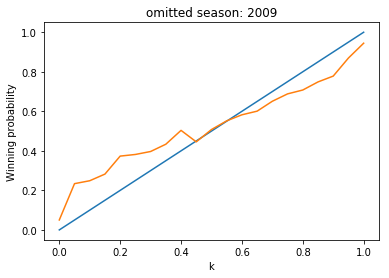

2010
mse: 0.011285943783627392
brier: 0.14842730567448081


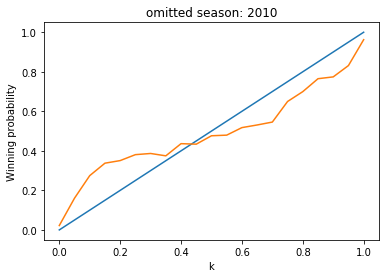

2011
mse: 0.00915757409966261
brier: 0.14522233991921396


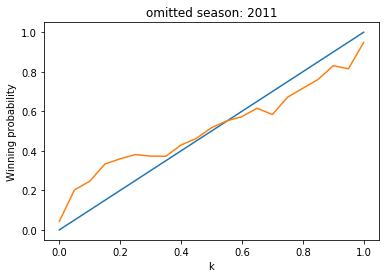

2012
mse: 0.012541308685293592
brier: 0.14109352311510565


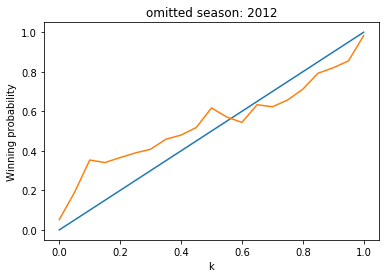

2013
mse: 0.012981986237277447
brier: 0.14820567473306012


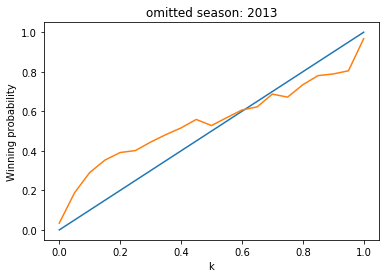

2014
mse: 0.00606999299950792
brier: 0.13170434296897568


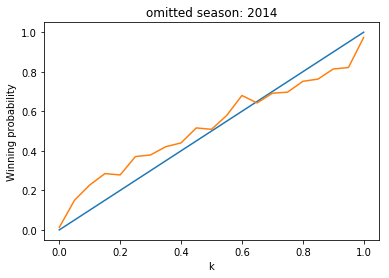

2015
mse: 0.008910261624558295
brier: 0.1529655929474955


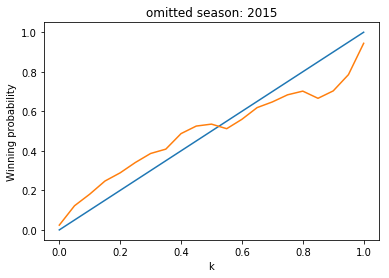

2016
mse: 0.008249459787995836
brier: 0.1518204191065431


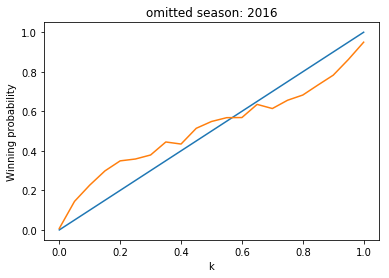

2017
mse: 0.0027790328403179427
brier: 0.12461881213607334


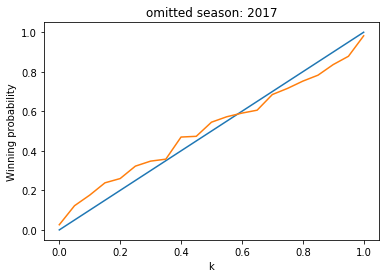

2018
mse: 0.014512791124444292
brier: 0.14191634702384495


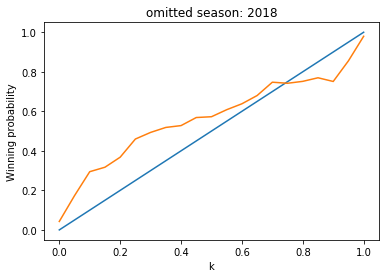


simplified model graphs
2009
mse: 0.010397065884851455
brier: 0.14222476758923885


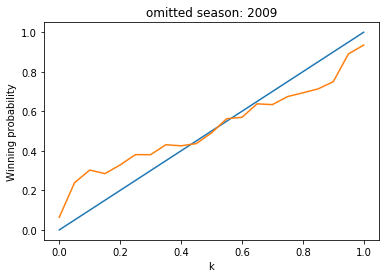

2010
mse: 0.010858977103665027
brier: 0.1481321094403477


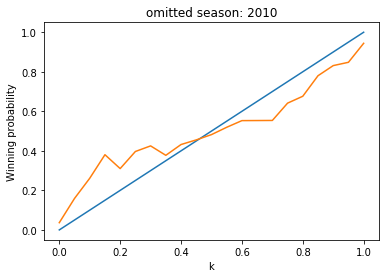

2011
mse: 0.010344728436440784
brier: 0.14799656665324093


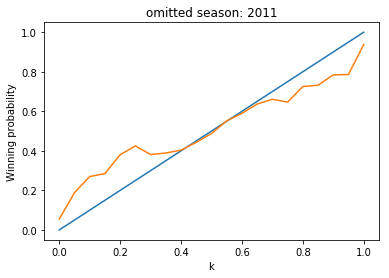

2012
mse: 0.012798700310699513
brier: 0.1413145930655777


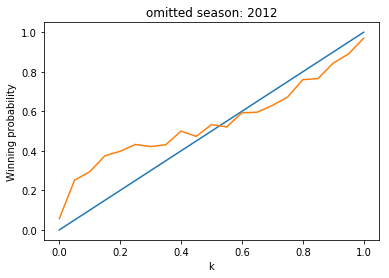

2013
mse: 0.012346496211218425
brier: 0.14652968389312473


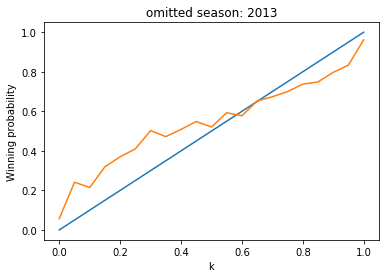

2014
mse: 0.0064508513412945305
brier: 0.1307853984068512


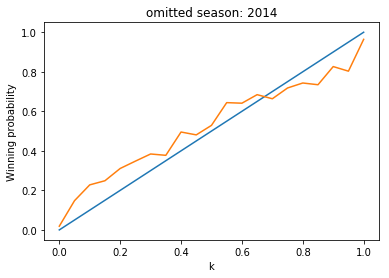

2015
mse: 0.008263134061665895
brier: 0.15035841399697847


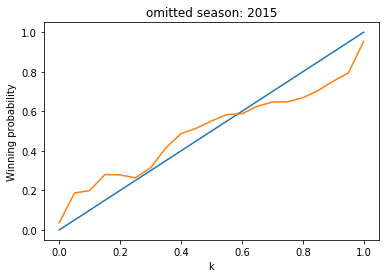

2016
mse: 0.006257834946662481
brier: 0.14997293158528735


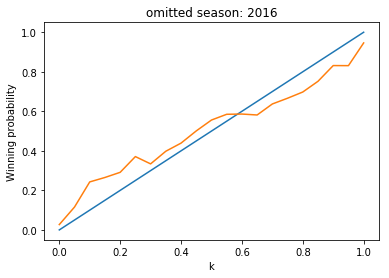

2017
mse: 0.0029651974994974076
brier: 0.12634930938127442


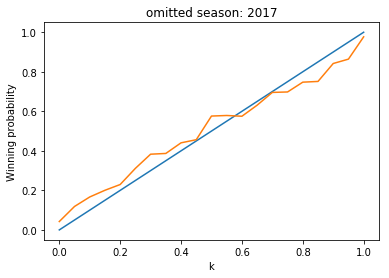

2018
mse: 0.013758782505071013
brier: 0.1410431935976996


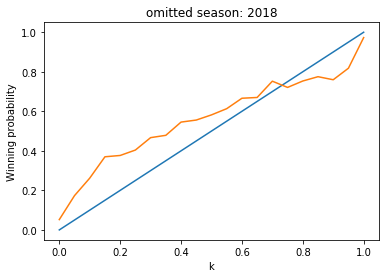

In [13]:
# model 1
x = np.arange(0, 1.01, 0.05)

print("full model")
ses1 = 0
for i in range(len(cv_means1)):
    ses1 += sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)
    
print("")
print("average mse: " + str(ses1/len(cv_means1)))
print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))

print("")
print("simplified model")
ses2 = 0
for i in range(len(cv_means2)):
    ses2 += sum([(cv_means2[i][j]-x[j])**2 for j in range(len(x))]) / len(x)
    
    
print("")
print("average mse: " + str(ses2/len(cv_means2)))
print("average brier score: " + str(sum(cv_briers2)/len(cv_briers2)))

print("")
print("full model graphs")
for i in range(len(cv_means1)):
    print(years[i])
    print("mse: " + str(sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
    print("brier: " + str(cv_briers1[i]))
    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,cv_means1[i])
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    plt.title("omitted season: " + str(years[i]))
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()
    
print("")
print("simplified model graphs")
for i in range(len(cv_means2)):
    print(years[i])
    print("mse: " + str(sum([(cv_means2[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
    print("brier: " + str(cv_briers2[i]))
    plt.close()
    plt.plot(x,x) # for reference
    plt.plot(x,cv_means2[i])
    plt.xlabel("k")
    plt.ylabel("Winning probability")
    plt.title("omitted season: " + str(years[i]))
    #plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
    plt.show()

### lock and nettleton

In [6]:
import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# get spread data
data = pd.read_csv("elo_and_vegas_spreads2.csv")

data = data.drop(data.columns[0], axis=1)
data = data[data["schedule_season"] >= 2009]
data = data[data["schedule_playoff"] == False]
data.drop(["schedule_playoff"],axis=1,inplace=True)

# get training and testing data
test_fraction = 0.3

years = [i for i in range(2009,2019)]
weeks = [i for i in range(1,18)]
plays = []
for y in years:
    plays.append(get_plays([y],weeks))

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [7]:
x_data = []
y_data = []
for i in range(len(plays)):
    x_data_cur, y_data_cur = collect_plays(plays[i])
    x_data.append(x_data_cur)
    y_data.append(y_data_cur)
    
train_x = []
test_x = []
train_y = []
test_y = []

for i in range(len(x_data)):
    cur_x = pd.concat([x_data[j] for j in range(len(x_data)) if j != i])
    cur_y = [y_data[j] for j in range(len(y_data)) if j != i]
    cur_y = [val for ylist in cur_y for val in ylist]
    train_x.append(cur_x)
    train_y.append(cur_y)
    test_x.append(x_data[i])
    test_y.append(y_data[i])

cols = list(train_x[0])
train_x2 = []
test_x2 = []
for i in range(len(train_x)):
    temp = pd.DataFrame(data=np.array(train_x[i]), columns=cols)
    train_x2.append(remove_features(temp))
    temp2 = pd.DataFrame(data=np.array(test_x[i]), columns=cols)
    test_x2.append(remove_features(temp2))


In [13]:
means1 = []
briers1 = []
means2 = []
briers2 = []
counts1 = [0 for i in range(21)]
counts2 = [0 for i in range(21)]
cv_means1 = []
cv_means2 = []
cv_briers1 = []
cv_briers2 = []

results1 = []
results2 = []

for i in range(len(train_x)):
    print(i)
    regressor = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
    regressor.fit(train_x[i], train_y[i])
    results1.append(regressor)
    
    regressor = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
    regressor.fit(train_x2[i], train_y[i])
    results2.append(regressor)

0
1
2
3
4
5
6
7
8
9


In [19]:
import math

# check accuracy using the brier score
def check_model_accuracy_times3(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    counts = []
    means = []
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean * cur_num)
        brier += cur_brier
        counts.append(cur_num)

    return y, brier, counts

def check_accuracy_lock_nettleton(x, y, model, start, end):
    cur_means, cur_brier, cur_count = check_model_accuracy_times3(x, y, model, start, end)
    
    return cur_means, cur_brier, cur_count, list(np.divide(np.array(cur_means), np.array(cur_count))), \
        cur_brier / sum(cur_count)

def check_accuracy_lock_nettleton_wrapper(test_x, test_y, results, start, end):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
def check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results, start, end, filename_start):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
    for i in range(len(cv_means1)):
        print(years[i])
        print("mse: " + str(sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
        print("brier: " + str(cv_briers1[i]))
        plt.close()
        plt.plot(x,x) # for reference
        plt.plot(x,cv_means1[i])
        plt.xlabel("k")
        plt.ylabel("Winning probability")
        plt.title("omitted season: " + str(years[i]))
        plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/diagrams/random_forests/byseason/"+filename_start+
                    str(years[i])+".png")
        plt.show()

In [25]:
# full model
print("full model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 15, 0)

# simplified model
print("simplified model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 15, 0)

full model 

full game
average mse: 0.009457179202935987
average brier score: 0.14222199117774786

1st quarter
average mse: 0.014578283657222187
average brier score: 0.21657161528348795

2nd quarter
average mse: 0.01205658767308393
average brier score: 0.18104153498599385

3rd quarter
average mse: 0.012204149618266335
average brier score: 0.13322393321598647

4th quarter
average mse: 0.01082082137037063
average brier score: 0.07906728512825552

simplified model 

full game
average mse: 0.009053212013981387
average brier score: 0.1416510450221254

1st quarter
average mse: 0.013668133381582173
average brier score: 0.21401824567196726

2nd quarter
average mse: 0.013275856470517548
average brier score: 0.18045867445275626

3rd quarter
average mse: 0.010901914637445918
average brier score: 0.13010299610363132

4th quarter
average mse: 0.010661123991253976
average brier score: 0.08130379111096947



#### bins

In [15]:
# full model
print("full model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x, test_y, results1, 15, 0)

# simplified model
print("simplified model \n")
print("full game")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 0)
print("1st quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 60, 45)
print("2nd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 45, 30)
print("3rd quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 30, 15)
print("4th quarter")
check_accuracy_lock_nettleton_wrapper(test_x2, test_y, results2, 15, 0)

full model 

full game
average mse: 0.00905632024864941
average brier score: 0.17365282321417852

1st quarter
average mse: 0.013920507630023601
average brier score: 0.22256510810609004

2nd quarter
average mse: 0.011200065556832074
average brier score: 0.19675082822628098

3rd quarter
average mse: 0.010828674928271958
average brier score: 0.1638344269618194

4th quarter
average mse: 0.008751824584910936
average brier score: 0.1184339108386191

simplified model 

full game
average mse: 0.008866810171107565
average brier score: 0.17423744102975508

1st quarter
average mse: 0.012981432328946288
average brier score: 0.2206382040556807

2nd quarter
average mse: 0.012060867703031311
average brier score: 0.19885172866448536

3rd quarter
average mse: 0.010589977162025525
average brier score: 0.1642105892186389

4th quarter
average mse: 0.008687981360852349
average brier score: 0.11978637046849752



full model

average mse: 0.00905632024864941
average brier score: 0.17365282321417852

2009
mse: 0.008888120565684946
brier: 0.17065846122266423


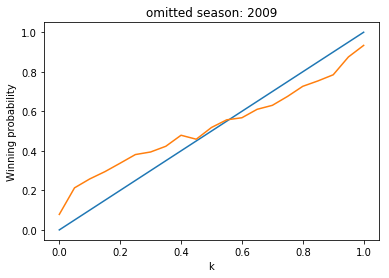

2010
mse: 0.010467819218307138
brier: 0.1804678230721336


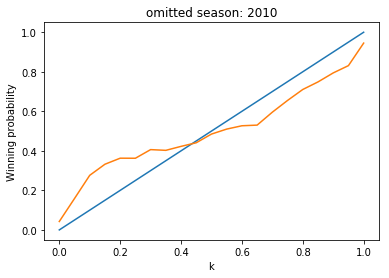

2011
mse: 0.010261929101129228
brier: 0.1786052286929558


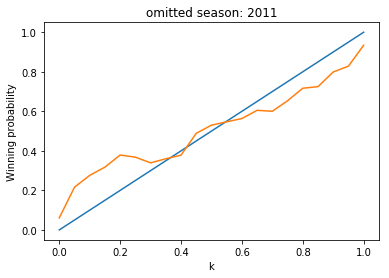

2012
mse: 0.010530125176222796
brier: 0.17313122503849998


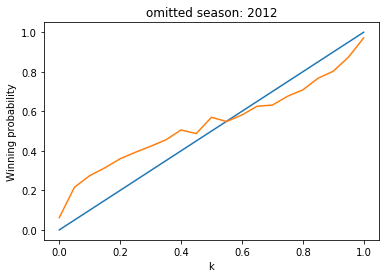

2013
mse: 0.013193987962147576
brier: 0.1804901839699136


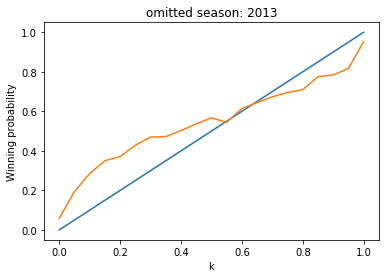

2014
mse: 0.006140267213009658
brier: 0.16400313581181786


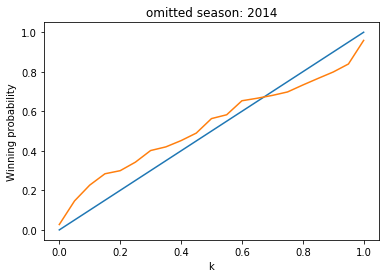

2015
mse: 0.008508969341979847
brier: 0.18344344585388406


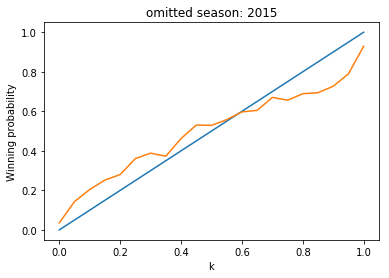

2016
mse: 0.008120566680836648
brier: 0.1818181363531469


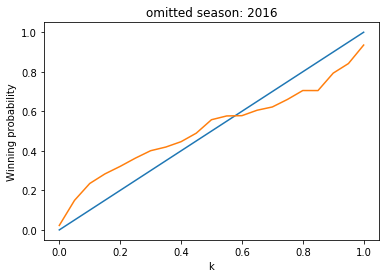

2017
mse: 0.0025979855772834152
brier: 0.15455992588931233


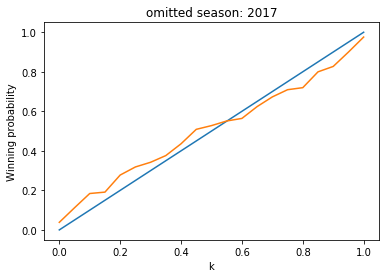

2018
mse: 0.011853431649892866
brier: 0.16935066623745693


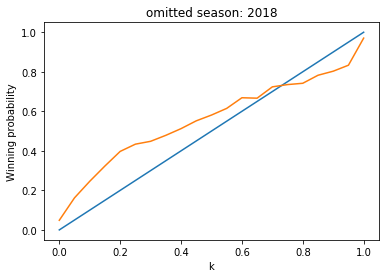

simplified model

average mse: 0.008866810171107565
average brier score: 0.17423744102975508

2009
mse: 0.00894637948761638
brier: 0.17259090107818836


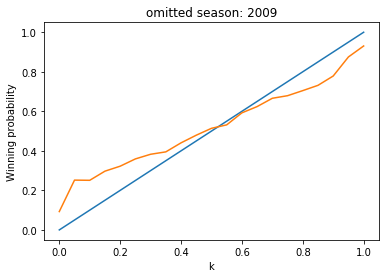

2010
mse: 0.010655281308812617
brier: 0.18025008953274732


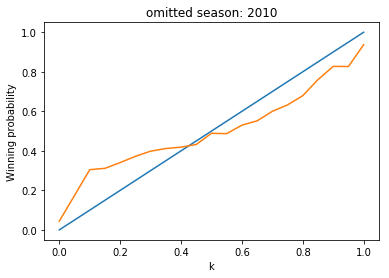

2011
mse: 0.009325768870532766
brier: 0.1776331622678827


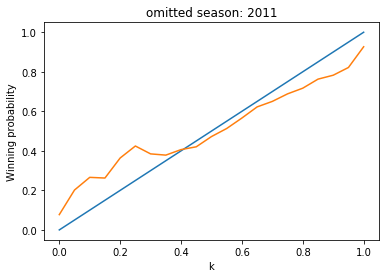

2012
mse: 0.0111556630329501
brier: 0.17559513369259908


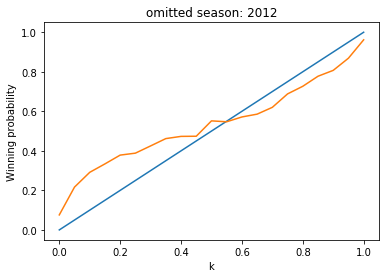

2013
mse: 0.011919824503953399
brier: 0.17985112819446644


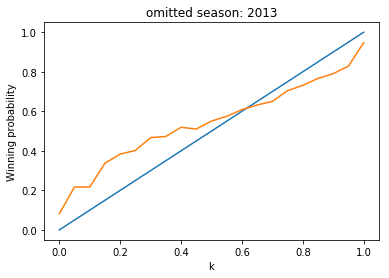

2014
mse: 0.006010658550614129
brier: 0.16372439448940634


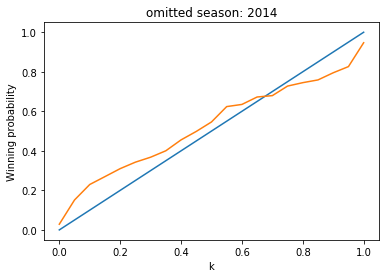

2015
mse: 0.008173787569038691
brier: 0.18298648406864557


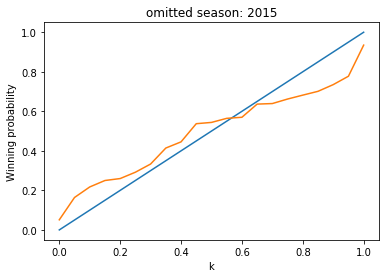

2016
mse: 0.006726182669378426
brier: 0.18006873822511582


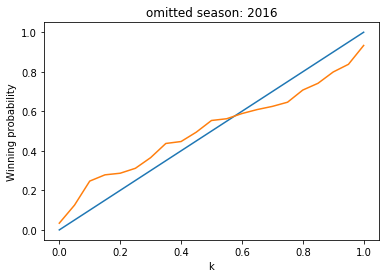

2017
mse: 0.003196906710058722
brier: 0.15805017239217856


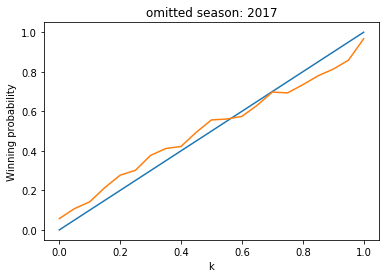

2018
mse: 0.012557649008120429
brier: 0.1716242063563207


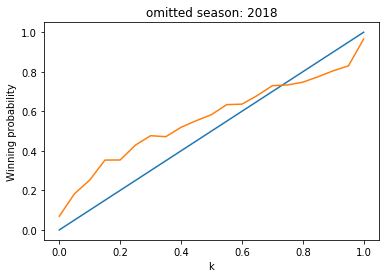

In [20]:
print("full model\n")
check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results1, 60, 0, "full")

print("simplified model\n")
check_accuracy_lock_nettleton_wrapper2(test_x2, test_y, results2, 60, 0, "simplified")

In [ ]:
#shitty older code

x = np.arange(0, 1.01, 0.05)

# model 1
print("full model")
count = sum(counts)
result1 = list(map(sum, zip(*means1)))
result1 = list(np.divide(np.array(result1), np.array(counts)))
brier1 = sum(briers1) / count

for i in range(len(result1)):
    print(str(round(x[i],2)) + ": " + str(round(result1[i],3)))

ses1 = [(result1[i]-x[i])**2 for i in range(len(result1))]
print("")
print("mse: " + str(sum(ses1)/len(ses1)))
print("brier score: " + str(brier1))
    
plt.close()
plt.plot(x,x) # for reference
plt.plot(x,result1)
plt.xlabel("k")
plt.ylabel("Winning probability")
#plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
plt.show()

print("")
# model 2
print("simplified model")
result2 = list(map(sum, zip(*means2)))
result2 = list(np.divide(np.array(result2), np.array(counts)))
brier2 = sum(briers2) / count

for i in range(len(result2)):
    print(str(round(x[i],2)) + ": " + str(round(result2[i],3)))

x = np.arange(0, 1.01, 0.05)
ses2 = [(result2[i]-x[i])**2 for i in range(len(result2))]
print("")
print("mse: " + str(sum(ses2)/len(ses2)))
print("brier score: " + str(brier2))
    
plt.close()
plt.plot(x,x) # for reference
plt.plot(x,result2)
plt.xlabel("k")
plt.ylabel("Winning probability")
#plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/interimreport/plot1.png")
plt.show()

## temporary

In [8]:
from sklearn.ensemble import RandomForestRegressor

means1 = []
briers1 = []
means2 = []
briers2 = []
counts1 = [0 for i in range(21)]
counts2 = [0 for i in range(21)]
cv_means1 = []
cv_means2 = []
cv_briers1 = []
cv_briers2 = []

results1 = []
results2 = []

for i in range(len(train_x)-2, len(train_x)-1):
    print(i)
    regressor = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
    regressor.fit(train_x[i], train_y[i])
    results1.append(regressor)
    
    regressor = RandomForestRegressor(n_estimators = 100, min_samples_leaf=10)
    regressor.fit(train_x2[i], train_y[i])
    results2.append(regressor)

8


In [11]:
import math

# check accuracy using the brier score
def check_model_accuracy_times3(old_test_x, old_test_y, model, start_time, end_time):
    indices = old_test_x.index[(old_test_x["time"] <= start_time) & (old_test_x["time"] >= end_time)].tolist()
    test_x = old_test_x.loc[indices, :]
    test_y = [old_test_y[i] for i in indices]
    
    #print(test_x.head())
    
    x = np.arange(0,1.01,0.05)
    y = []
    brier = 0
    counts = []
    means = []
    for i in x:
        cur_mean, cur_brier, cur_num = get_brier(test_x, test_y, model, i)
        y.append(cur_mean * cur_num)
        brier += cur_brier
        counts.append(cur_num)

    return y, brier, counts

def check_accuracy_lock_nettleton(x, y, model, start, end):
    cur_means, cur_brier, cur_count = check_model_accuracy_times3(x, y, model, start, end)
    
    return cur_means, cur_brier, cur_count, list(np.divide(np.array(cur_means), np.array(cur_count))), \
        cur_brier / sum(cur_count)

def check_accuracy_lock_nettleton_wrapper(test_x, test_y, results, start, end):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
def check_accuracy_lock_nettleton_wrapper2(test_x, test_y, results, start, end, filename_start):
    means1 = []
    briers1 = []
    counts1 = [0 for i in range(21)]
    cv_means1 = []
    cv_briers1 = []

    for i in range(len(test_x)):
        cur1, cur2, cur3, cur4, cur5 = check_accuracy_lock_nettleton(test_x[i], test_y[i], results[i], start, end)
        means1.append(cur1)
        briers1.append(cur2)
        counts1 = list(np.array(counts1) + np.array(cur3))
        cv_means1.append(cur4)
        cv_briers1.append(cur5)

    # model 1
    x = np.arange(0, 1.01, 0.05)

    ses1 = [0 for i in range(len(cv_means1))]
    count1 = 0
    for i in range(len(cv_means1)):
        for j in range(len(cv_means1[i])):
            if math.isnan(cv_means1[i][j]):
                continue
            ses1[i] += (cv_means1[i][j]-x[j])**2
            count1 += 1
        ses1[i] = ses1[i] / count1
        count1 = 0

    print("average mse: " + str(sum(ses1)/(len(cv_means1))))
    print("average brier score: " + str(sum(cv_briers1)/len(cv_briers1)))
    print("")
    
    for i in range(len(cv_means1)):
        print(years[i])
        print("mse: " + str(sum([(cv_means1[i][j]-x[j])**2 for j in range(len(x))]) / len(x)))
        print("brier: " + str(cv_briers1[i]))
        plt.close()
        plt.plot(x,x) # for reference
        plt.plot(x,cv_means1[i])
        plt.xlabel("k")
        plt.ylabel("Winning probability")
        plt.title("omitted season: 2017")
        plt.savefig("/Users/Bill/Documents/Fall 2019/THesis/thesis/Figures/random_forests/byseason/"+filename_start+
                    "2017_last5.png")
        plt.show()

full model

average mse: 0.01558262023179854
average brier score: 0.07266869276168951

2009
mse: 0.01558262023179854
brier: 0.07266869276168951


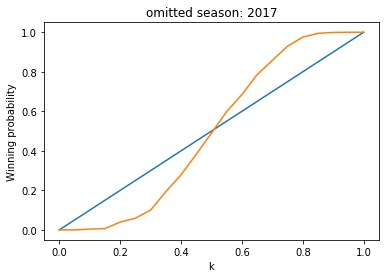

simplified model

average mse: 0.013222725895398338
average brier score: 0.07737631381464347

2009
mse: 0.013222725895398338
brier: 0.07737631381464347


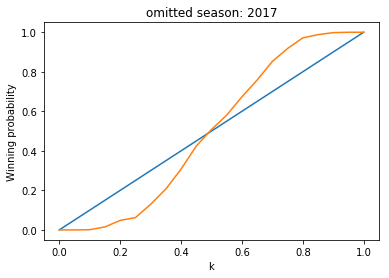

In [12]:
print("full model\n")
check_accuracy_lock_nettleton_wrapper2([test_x[-1]], [test_y[-1]], results1, 60, 0, "full")

print("simplified model\n")
check_accuracy_lock_nettleton_wrapper2([test_x2[-1]], [test_y[-1]], results2, 60, 0, "simplified")